#Using Word2Vec to work with Yelp Review Text

In [37]:
import pandas as pd
import sklearn as sk
import numpy as np
import time

In [57]:
#Read in review data

## Commented this out; created a smaller csv to work with because my computer can't handle 
## reviews and business data simultaneously.

reviews = pd.read_csv("data\yelp_academic_dataset_review.csv")
#rvws = reviews.iloc[:5000,:]
#rvws.to_csv("yelp_dataset_5k_review.csv")

#Below csv was created previously using the first 5,000 reviews. Once this is a working model we can expand it to a fuller dataset.
#rvws = pd.read_csv("data\yelp_dataset_5k_review.csv")

In [58]:
#It's a HUGE dataset, so let's make a smaller one to work with until we have everything figured out.
#I've created a smaller one with the first 5,000 reviews.
reviews.describe()

,votes.cool,votes.funny,stars,votes.useful
count,1569264.000000,1569264.000000,1569264.000000,1569264.00000
mean,0.594182,0.478886,3.742656,1.07162
std,1.617808,1.538368,1.311468,2.05166
min,0.000000,0.000000,1.000000,0.00000
25%,0.000000,0.000000,3.000000,0.00000
50%,0.000000,0.000000,4.000000,0.00000
75%,1.000000,0.000000,5.000000,1.00000
max,137.000000,141.000000,5.000000,166.00000


In [59]:
## To make things easier when trying to analyze the text, let's just look at restaurants. For that, we'll have to join the review
## and business data. I'm also pulling the city and state so I can add location later on if I desire to.
headers = ['categories','business_id','city','state']
business = pd.read_csv("data\yelp_academic_dataset_business.csv", usecols = headers)


In [54]:
## Now that we have the data joined with the business information, we can narrow the dataset to just restaurants so that
## the language we are looking for is more consistent. 
## (e.g. a good doctor review will have differnt language than a good restaurant review)

reviews = pd.merge(reviews, business, on = 'business_id')
cat = reviews['categories']
rest = []

for x in range(len(cat)):
    if "Restaurants" in cat[x]:
        rest.append(1)
    else:
        rest.append(0)

reviews['restaurant'] = rest

## This will modify our reviews DataFrame to only include business that fall into the "restaurants" category.
reviews = reviews[reviews['restaurant'] == 1]
reviews = reviews.reset_index(drop=True)

In [55]:
text = reviews[['text']]
stars = reviews[['stars']]

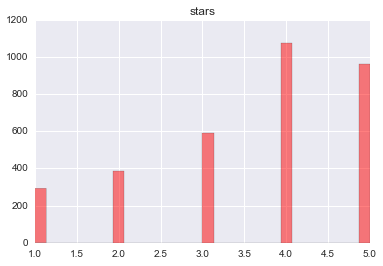

In [56]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
ax = stars.hist(color='red', alpha=0.5, bins = 30)

In [18]:
print stars.describe()

             stars
count  3307.000000
mean      3.612035
std       1.258635
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000


### Let's work with the text to make it into something that can be fitted by Word2Vec. To save time, skip this and load the vectors in the next section.

In [12]:
## Import necessary libraries and define function that will make text all lower case and remove stop words.

import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics import roc_curve, auc

def review_to_wordlist(review, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    review_text = review   
    
    # 1. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # 2. Convert words to lower case and split them
    words = review_text.lower().split()

    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    # 5. Return a list of words
    return(words)

In [ ]:
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
sentences = tokenizer.tokenize(train["review"][0])
print sentences[0], "\n"
print sentences[1]

In [ ]:
def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words

    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())

    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list o`f words
            sentences.append( review_to_wordlist( raw_sentence, remove_stopwords ))

    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [14]:
%%time

sentences = []

print "Parsing sentences from training set"
for text in reviews["text"]:
    try:
        sentences += review_to_sentences(review, tokenizer)
    except Exception as e:
        print "Execption raised:", e


In [ ]:
%%time
# Set values for various Word2Vec parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. This might take some time.
print "Training model..."
model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

In [ ]:
## Save the model to a .bin file so it can easily be re-loaded for future use
model.save("yelpReviews-vectors-100.bin")
model.init_sims(replace=True)

### Uncomment below to load vectors

In [ ]:
## Uncomment the below line to import word2vec vectors which was created on Yelp review text for restaurants
# model = Word2Vec.load_word2vec_format(models\yelpReviews-vectors-100.bin', binary=True)

## Alternatively, you can use the google vectors generated from Google News:
#model = Word2Vec.load_word2vec_format('data\GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
## Define a function that will average all of the vectors in a given review, to account for varying lengths of each review
def get_avg_vec(words, model, num_features):

    # Pre-initialize an empty numpy array (for speed)
    feature_vec = np.zeros((num_features,),dtype="float32")

    nwords = 0.

    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)

    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec, model[word])

    # Divide the result by the number of words to get the average
    feature_vec = np.divide(feature_vec, nwords)
    
    return feature_vec

In [40]:
%%time
## pass through review text and get the average vector for each review.

reviews_text_vec = []
for x in reviews_text:
    reviews_text_vec.append(get_avg_vec(x, model, 300))
print reviews_text_vec[:5]

[array([ -1.24879330e-02,   1.62466709e-02,   6.19000988e-03,
         5.51948994e-02,  -1.55467466e-02,  -8.10502563e-03,
         1.36002917e-02,  -1.89857949e-02,   2.92995535e-02,
         4.08151224e-02,  -5.09202946e-03,  -3.47345397e-02,
         2.11036392e-03,  -1.15223108e-02,  -3.66390683e-02,
         2.97466405e-02,   1.45018363e-04,   3.65637653e-02,
         8.21500609e-04,  -1.50255077e-02,  -2.03647278e-03,
         1.52606452e-02,   2.47699395e-02,  -5.80853026e-04,
         1.43288653e-02,  -1.90452654e-02,  -3.30012329e-02,
         3.14831324e-02,   2.49893218e-03,  -5.83657390e-03,
        -1.31177539e-02,   1.38138998e-02,   4.00991784e-03,
        -4.60440153e-03,  -1.03783095e-03,   2.70899129e-03,
         2.54246294e-02,  -3.15923546e-03,   1.12307984e-02,
         3.02048139e-02,   2.72526182e-02,  -3.93570103e-02,
         5.63304499e-02,  -4.53120656e-03,   3.38027813e-03,
        -1.48360012e-02,  -2.97581255e-02,   3.73258675e-03,
         3.57741653e-03

###Run Random Forests Classifier

In [42]:
reviews['good'] = (reviews['stars'] > 3)
good = reviews['good']

In [49]:
reviews_text_vec_array = np.array(reviews_text_vec)


numpy.ndarray

In [50]:
## Define and fit the model

forest = sk.linear_model.RandomForestClassifier(n_estimators = 5)
forest.fit(reviews_text_vec_array, reviews)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [31]:
## Plot ROC curve to see how it performs
pred_probas = log.predict_proba(good)[:,1]

false_pos_rate, true_pos_rate, thresholds = roc_curve(good, pred_probas)
roc_auc = auc(false_pos_rate, true_pos_rate)
plt.plot(false_pos_rate, true_pos_rate, label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

NotFittedError: This LogisticRegression instance is not fittedyet